<a href="https://www.kaggle.com/code/guilhermeparcerao/mafaulda-tinyml-training-for-fault-detection?scriptVersionId=197373894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MAFAULDA TinyML Training for Fault Detection

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.fft import rfft, rfftfreq
from time import time
import tensorflow as tf
from os.path import join
from os import walk
from gc import collect
from warnings import filterwarnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
filterwarnings("ignore", category=InterpolationWarning)

## Database load and creation

Legend according to [MAFAULDA docs](https://www02.smt.ufrj.br/~offshore/mfs/page_01.html):

* Column 1: tachometer signal that allows to estimate rotation frequency;
* Columns 2 to 4: underhang bearing accelerometer (axial, radiale tangential direction);
* Columns 5 to 7: overhang bearing accelerometer (axial, radiale tangential direction);
* Column 8: microphone.

Custom classification legend:

* 0: normal;
* 1: horizontal misalignment;
* 2: vertical misalignment;
* 3: imbalance;

In [4]:
df_normal = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/normal'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_normal = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_normal['class'] = 0
df_normal.reset_index(inplace=True, drop=True)
df_normal

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,4.45120,0.715890,-0.284200,-0.156640,0.15180,0.043086,-0.132050,0.250240,0
1,4.43510,-0.611990,-0.036589,-0.177420,0.14875,0.042284,-0.053911,-0.153740,0
2,4.43840,0.964500,0.084935,-0.118130,0.19624,0.048849,0.131020,0.099203,0
3,4.44640,-0.725030,-0.217920,-0.138780,0.12676,0.047700,0.153350,0.030619,0
4,4.42500,1.027400,0.379270,0.004222,0.18157,0.052898,0.326180,-0.079583,0
...,...,...,...,...,...,...,...,...,...
3249995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.412460,0.563960,0
3249996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.355020,-0.231140,0
3249997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.294860,0.325030,0
3249998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.116480,0.127020,0


In [5]:
df_hmis = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/horizontal-misalignment/0.5mm'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_hmis = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_hmis['class'] = 1
df_hmis.reset_index(inplace=True, drop=True)
df_hmis

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,-0.72336,0.025037,0.408920,0.984850,-2.28670,0.016242,-0.70277,-0.019858,1
1,-0.70719,0.227100,-0.074799,0.887990,-2.44420,0.016376,-0.67076,0.042788,1
2,-0.71950,0.495530,0.596450,0.758660,-2.46360,0.026754,-0.37686,-0.154130,1
3,-0.71358,0.223710,-0.262470,0.359920,-2.72180,0.024334,-0.38949,0.139290,1
4,-0.71142,0.567930,0.721270,0.128770,-2.51380,0.025836,-0.29535,-0.228650,1
...,...,...,...,...,...,...,...,...,...
3299995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.41246,0.563960,1
3299996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.35502,-0.231140,1
3299997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.29486,0.325030,1
3299998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.11648,0.127020,1


In [6]:
df_vmis = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/vertical-misalignment/0.51mm'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_vmis = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_vmis['class'] = 2
df_vmis.reset_index(inplace=True, drop=True)
df_vmis

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,-0.26741,1.211400,0.427410,0.061238,-0.19592,-0.041349,-0.21933,0.001510,2
1,-0.48245,-0.019217,-0.294830,0.055033,-0.20795,-0.043865,-0.25106,-0.050378,2
2,-0.24893,1.019200,0.572310,0.015552,-0.20656,-0.045597,-0.21984,-0.064932,2
3,-0.51596,0.315670,-0.254680,-0.146800,-0.21867,-0.050962,-0.28568,-0.015210,2
4,-0.28917,0.531090,0.451630,-0.203780,-0.21712,-0.053472,-0.28891,-0.119280,2
...,...,...,...,...,...,...,...,...,...
3299995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.41246,0.563960,2
3299996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.35502,-0.231140,2
3299997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.29486,0.325030,2
3299998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.11648,0.127020,2


In [7]:
df_imb = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/imbalance/10g'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_imb = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_imb['class'] = 3
df_imb.reset_index(inplace=True, drop=True)
df_imb

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,-0.67757,-0.704340,-0.508310,-0.011726,-0.006906,0.003182,0.25950,-0.110830,3
1,-0.64563,1.002800,-0.097861,-0.001289,-0.002956,0.006031,0.26768,0.103170,3
2,-0.69777,-0.647460,-0.522130,-0.111690,-0.015261,-0.000104,0.22027,0.105750,3
3,-0.64700,0.858420,0.128700,0.001961,-0.008408,0.000654,0.40810,-0.101970,3
4,-0.66406,-0.403070,-0.559650,-0.098031,-0.014979,-0.002433,0.26694,0.252020,3
...,...,...,...,...,...,...,...,...,...
3299995,-0.76078,-0.546360,-0.863020,-0.017809,0.398010,-0.013208,0.41246,0.563960,3
3299996,-0.65087,-0.847700,-0.290520,0.011313,0.406640,-0.011739,0.35502,-0.231140,3
3299997,-0.72317,-0.091599,-0.489430,-0.121290,0.368010,-0.008408,0.29486,0.325030,3
3299998,-0.70948,-1.160600,-0.542830,-0.296920,0.224810,-0.011758,0.11648,0.127020,3


In [8]:
df_raw_general = pd.concat([df_normal, df_hmis, df_vmis, df_imb])
df_raw_general.reset_index(inplace=True, drop=True)
df_raw_general

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,4.45120,0.715890,-0.284200,-0.156640,0.15180,0.043086,-0.132050,0.250240,0
1,4.43510,-0.611990,-0.036589,-0.177420,0.14875,0.042284,-0.053911,-0.153740,0
2,4.43840,0.964500,0.084935,-0.118130,0.19624,0.048849,0.131020,0.099203,0
3,4.44640,-0.725030,-0.217920,-0.138780,0.12676,0.047700,0.153350,0.030619,0
4,4.42500,1.027400,0.379270,0.004222,0.18157,0.052898,0.326180,-0.079583,0
...,...,...,...,...,...,...,...,...,...
13149995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.412460,0.563960,3
13149996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.355020,-0.231140,3
13149997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.294860,0.325030,3
13149998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.116480,0.127020,3


## Data validation and preparation

Result for isna test: False
Result for duplicated test: False


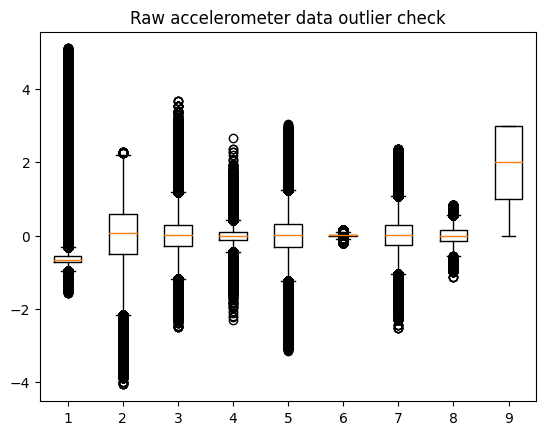

In [9]:
raw_general_isna = df_raw_general.isna().values.any()
raw_general_duplicated = df_raw_general.duplicated().values.any()
print(f"Result for isna test: {raw_general_isna}")
print(f"Result for duplicated test: {raw_general_duplicated}")
plt.title("Raw accelerometer data outlier check")
plt.boxplot(df_raw_general)
plt.show()

In [ ]:
def test_stationarity(series):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags='auto')

    return {
        "adf_statistic": adf_result[0],
        "adf_pvalue": adf_result[1],
        "kpss_statistic": kpss_result[0],
        "kpss_pvalue": kpss_result[1],
    }

def plot_rolling_stats(final_df, axis):
    plt.figure(figsize=(10, 6))
    rolling_mean = final_df[axis].rolling(window=50).mean()
    rolling_variance = final_df[axis].rolling(window=50).var()
    plt.plot(final_df[axis], label=f'{axis} axis signal')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_variance, label='Rolling Variance', color='green')
    plt.title(f'Rolling Mean & Variance - {axis} Axis (Final Result)')
    plt.legend()
    plt.show()

chunk_size = 100000
chunks = np.array_split(df_raw_general, np.ceil(len(df_raw_general) / chunk_size))
prev_chunk_end = None
final_df = pd.DataFrame()
stationarity_results = {axis: {"adf_statistic": 0, "adf_pvalue": 0, "kpss_statistic": 0, "kpss_pvalue": 0} for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']}
n_chunks = len(chunks)
start_time = time()

for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i+1}/{n_chunks}")
    chunk_start_time = time()

    if prev_chunk_end is not None:
        chunk = pd.concat([prev_chunk_end, chunk], ignore_index=True)

    for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']:
        test_results = test_stationarity(chunk[axis])
        stationarity_results[axis]["adf_statistic"] += test_results["adf_statistic"] / n_chunks
        stationarity_results[axis]["adf_pvalue"] += test_results["adf_pvalue"] / n_chunks
        stationarity_results[axis]["kpss_statistic"] += test_results["kpss_statistic"] / n_chunks
        stationarity_results[axis]["kpss_pvalue"] += test_results["kpss_pvalue"] / n_chunks

    prev_chunk_end = chunk.iloc[-50:]
    final_df = pd.concat([final_df, chunk], ignore_index=True)
    del chunk
    collect()
    chunk_time = time() - chunk_start_time
    print(f"Chunk {i+1} processed in {chunk_time:.2f} seconds.")

print("\n--- Final Stationarity Results ---")

for axis, results in stationarity_results.items():
    print(f"--- {axis} axis ---")
    print(f"ADF Statistic: {results['adf_statistic']}")
    print(f"ADF p-value: {results['adf_pvalue']}")
    print(f"KPSS Statistic: {results['kpss_statistic']}")
    print(f"KPSS p-value: {results['kpss_pvalue']}")
    print("ADF Test indicates stationarity" if results['adf_pvalue'] < 0.05 else "ADF Test indicates non-stationarity")
    print("KPSS Test indicates stationarity" if results['kpss_pvalue'] > 0.05 else "KPSS Test indicates non-stationarity")
    print()

for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']:
    plot_rolling_stats(final_df, axis)

total_time = time() - start_time
print(f"All chunks processed in {total_time:.2f} seconds.")

In [11]:
SAMPLE_RATE = 51200 # from MAFAULDA documentation

In [13]:
def accel_fft_spectrum(x, y, z, n_samples):
    x_accel = x - np.mean(x)
    y_accel = y - np.mean(y)
    z_accel = z - np.mean(z)
    
    yf1 = rfft(x_accel)
    yf2 = rfft(y_accel)
    yf3 = rfft(z_accel)
    xf = rfftfreq(n_samples, 1/SAMPLE_RATE)
    
    plt.plot(xf, np.abs(yf1), color='blue')
    plt.plot(xf, np.abs(yf2), color='green')
    plt.plot(xf, np.abs(yf3), color='yellow')

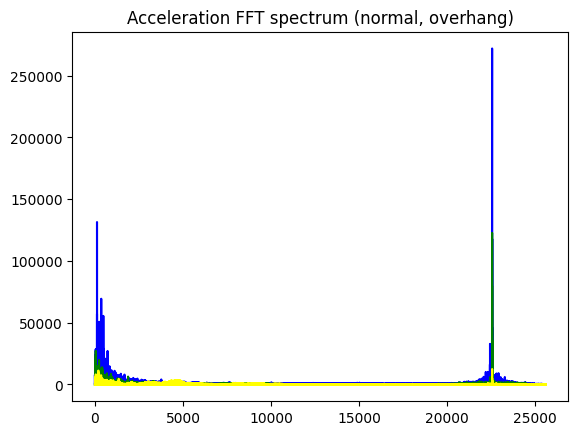

In [14]:
accel_fft_spectrum(df_normal.iloc[:,1].values, df_normal.iloc[:,2].values, df_normal.iloc[:,3].values, df_normal.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (normal, overhang)")
plt.show()

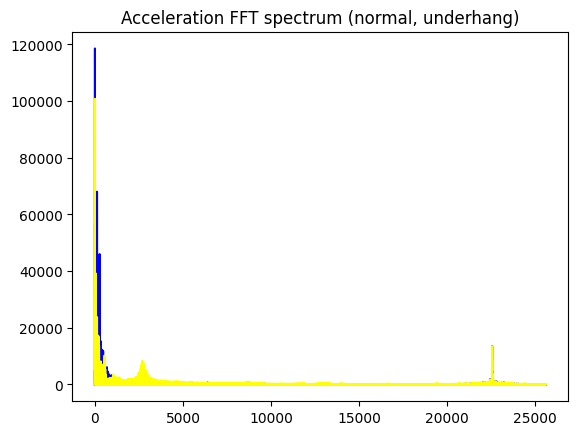

In [15]:
accel_fft_spectrum(df_normal.iloc[:,4].values, df_normal.iloc[:,5].values, df_normal.iloc[:,6].values, df_normal.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (normal, underhang)")
plt.show()

In [16]:
n_samples = df_normal.shape[0]

uhang_x_fft = rfft(df_normal.iloc[:, 1].values)
uhang_y_fft = rfft(df_normal.iloc[:, 2].values)
uhang_z_fft = rfft(df_normal.iloc[:, 3].values)
uhang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

ohang_x_fft = rfft(df_normal.iloc[:, 4].values)
ohang_y_fft = rfft(df_normal.iloc[:, 5].values)
ohang_z_fft = rfft(df_normal.iloc[:, 6].values)
ohang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

df_fft_normal = pd.DataFrame()
n_fft_samples = len(uhang_x_fft)

df_fft_normal['uhang_x_fft'] = np.abs(uhang_x_fft)
df_fft_normal['uhang_x_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_normal['uhang_y_fft'] = np.abs(uhang_y_fft)
df_fft_normal['uhang_y_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_normal['uhang_z_fft'] = np.abs(uhang_z_fft)
df_fft_normal['uhang_z_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]

df_fft_normal['ohang_x_fft'] = np.abs(ohang_x_fft)
df_fft_normal['ohang_x_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_normal['ohang_y_fft'] = np.abs(ohang_y_fft)
df_fft_normal['ohang_y_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_normal['ohang_z_fft'] = np.abs(ohang_z_fft)
df_fft_normal['ohang_z_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]

df_fft_normal['class'] = 0
df_fft_normal

,uhang_x_fft,uhang_x_fftfreq,uhang_y_fft,uhang_y_fftfreq,uhang_z_fft,uhang_z_fftfreq,ohang_x_fft,ohang_x_fftfreq,ohang_y_fft,ohang_y_fftfreq,ohang_z_fft,ohang_z_fftfreq,class
0,21616.221251,0.000000,1567.149749,0.000000,1223.434822,0.000000,23848.618686,0.000000,9972.318879,0.000000,49560.981165,0.000000,0
1,5742.650242,0.015754,105.751529,0.015754,51.932929,0.015754,16691.299925,0.015754,447.578563,0.015754,35183.532660,0.015754,0
2,7845.537518,0.031508,51.593655,0.031508,109.278624,0.031508,8729.590188,0.031508,60.344975,0.031508,33203.617102,0.031508,0
3,4401.388499,0.047262,111.283466,0.047262,14.311252,0.047262,11646.350445,0.047262,1508.572881,0.047262,27581.007948,0.047262,0
4,5235.894598,0.063015,93.537965,0.063015,168.366644,0.063015,31423.161942,0.063015,536.473656,0.063015,56878.048090,0.063015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624996,85.837251,25599.936985,67.790280,25599.936985,25.723858,25599.936985,26.750153,25599.936985,1.536272,25599.936985,9.624044,25599.936985,0
1624997,147.597381,25599.952738,80.717759,25599.952738,21.460374,25599.952738,11.833946,25599.952738,0.270773,25599.952738,5.664612,25599.952738,0
1624998,52.492515,25599.968492,114.552680,25599.968492,21.952729,25599.968492,21.758145,25599.968492,4.406284,25599.968492,11.084380,25599.968492,0
1624999,35.024710,25599.984246,81.417087,25599.984246,50.600136,25599.984246,17.488393,25599.984246,6.915516,25599.984246,13.632489,25599.984246,0


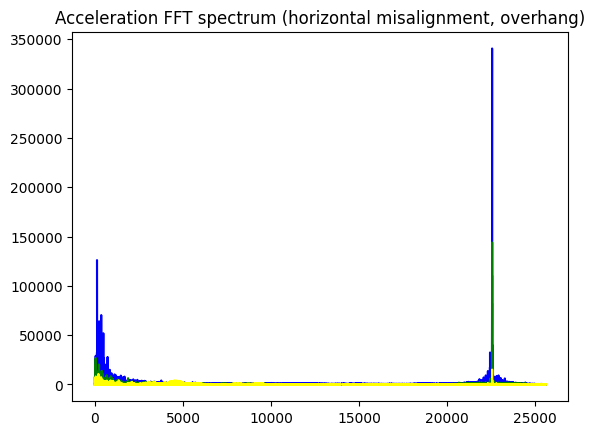

In [17]:
accel_fft_spectrum(df_hmis.iloc[:,1].values, df_hmis.iloc[:,2].values, df_hmis.iloc[:,3].values, df_hmis.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (horizontal misalignment, overhang)")
plt.show()

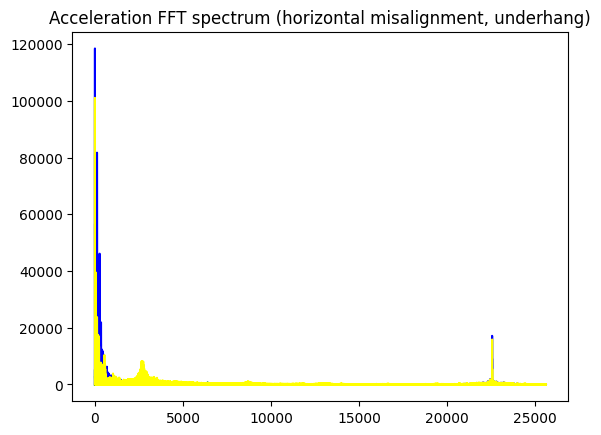

In [18]:
accel_fft_spectrum(df_hmis.iloc[:,4].values, df_hmis.iloc[:,5].values, df_hmis.iloc[:,6].values, df_hmis.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (horizontal misalignment, underhang)")
plt.show()

In [20]:
n_samples = df_hmis.shape[0]

uhang_x_fft = rfft(df_hmis.iloc[:, 1].values)
uhang_y_fft = rfft(df_hmis.iloc[:, 2].values)
uhang_z_fft = rfft(df_hmis.iloc[:, 3].values)
uhang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

ohang_x_fft = rfft(df_hmis.iloc[:, 4].values)
ohang_y_fft = rfft(df_hmis.iloc[:, 5].values)
ohang_z_fft = rfft(df_hmis.iloc[:, 6].values)
ohang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

df_fft_hmis = pd.DataFrame()
n_fft_samples = len(uhang_x_fft)

df_fft_hmis['uhang_x_fft'] = np.abs(uhang_x_fft)
df_fft_hmis['uhang_x_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_hmis['uhang_y_fft'] = np.abs(uhang_y_fft)
df_fft_hmis['uhang_y_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_hmis['uhang_z_fft'] = np.abs(uhang_z_fft)
df_fft_hmis['uhang_z_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]

df_fft_hmis['ohang_x_fft'] = np.abs(ohang_x_fft)
df_fft_hmis['ohang_x_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_hmis['ohang_y_fft'] = np.abs(ohang_y_fft)
df_fft_hmis['ohang_y_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_hmis['ohang_z_fft'] = np.abs(ohang_z_fft)
df_fft_hmis['ohang_z_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]

df_fft_hmis['class'] = 1
df_fft_hmis

,uhang_x_fft,uhang_x_fftfreq,uhang_y_fft,uhang_y_fftfreq,uhang_z_fft,uhang_z_fftfreq,ohang_x_fft,ohang_x_fftfreq,ohang_y_fft,ohang_y_fftfreq,ohang_z_fft,ohang_z_fftfreq,class
0,22105.241411,0.000000,1556.740848,0.000000,1249.723217,0.000000,17238.767431,0.000000,10159.848909,0.000000,46015.699872,0.000000,1
1,5871.617487,0.015515,137.937315,0.015515,43.879220,0.015515,22233.508959,0.015515,444.679080,0.015515,38911.028072,0.015515,1
2,7883.267977,0.031030,24.836654,0.031030,108.951272,0.031030,4162.241599,0.031030,41.830329,0.031030,30833.250601,0.031030,1
3,3932.775728,0.046545,119.942327,0.046545,10.162559,0.046545,17950.327467,0.046545,1440.471691,0.046545,28593.702348,0.046545,1
4,5359.993812,0.062061,112.496275,0.062061,171.790382,0.062061,29861.402778,0.062061,676.312560,0.062061,56251.761936,0.062061,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649996,71.959366,25599.937939,68.087177,25599.937939,29.772332,25599.937939,27.446818,25599.937939,2.096013,25599.937939,9.365936,25599.937939,1
1649997,146.989505,25599.953455,86.805935,25599.953455,18.562373,25599.953455,10.403025,25599.953455,0.406089,25599.953455,5.845390,25599.953455,1
1649998,61.837830,25599.968970,124.498933,25599.968970,25.745479,25599.968970,21.774289,25599.968970,4.106327,25599.968970,12.434537,25599.968970,1
1649999,27.400337,25599.984485,90.073291,25599.984485,47.897313,25599.984485,18.378005,25599.984485,6.956911,25599.984485,15.114815,25599.984485,1


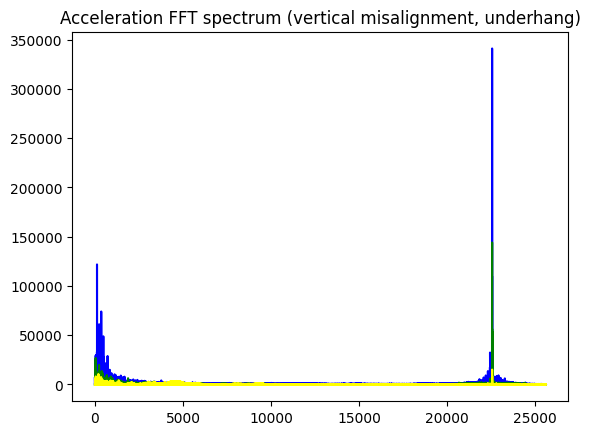

In [21]:
accel_fft_spectrum(df_vmis.iloc[:,1].values, df_vmis.iloc[:,2].values, df_vmis.iloc[:,3].values, df_vmis.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (vertical misalignment, underhang)")
plt.show()

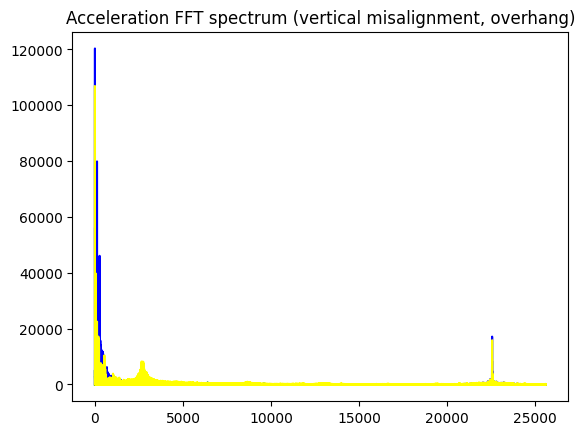

In [22]:
accel_fft_spectrum(df_vmis.iloc[:,4].values, df_vmis.iloc[:,5].values, df_vmis.iloc[:,6].values, df_vmis.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (vertical misalignment, overhang)")
plt.show()

In [23]:
n_samples = df_hmis.shape[0]

uhang_x_fft = rfft(df_hmis.iloc[:, 1].values)
uhang_y_fft = rfft(df_hmis.iloc[:, 2].values)
uhang_z_fft = rfft(df_hmis.iloc[:, 3].values)
uhang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

ohang_x_fft = rfft(df_hmis.iloc[:, 4].values)
ohang_y_fft = rfft(df_hmis.iloc[:, 5].values)
ohang_z_fft = rfft(df_hmis.iloc[:, 6].values)
ohang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

df_fft_vmis = pd.DataFrame()
n_fft_samples = len(uhang_x_fft)

df_fft_vmis['uhang_x_fft'] = np.abs(uhang_x_fft)
df_fft_vmis['uhang_x_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_vmis['uhang_y_fft'] = np.abs(uhang_y_fft)
df_fft_vmis['uhang_y_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_vmis['uhang_z_fft'] = np.abs(uhang_z_fft)
df_fft_vmis['uhang_z_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]

df_fft_vmis['ohang_x_fft'] = np.abs(ohang_x_fft)
df_fft_vmis['ohang_x_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_vmis['ohang_y_fft'] = np.abs(ohang_y_fft)
df_fft_vmis['ohang_y_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_vmis['ohang_z_fft'] = np.abs(ohang_z_fft)
df_fft_vmis['ohang_z_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]

df_fft_vmis['class'] = 2
df_fft_vmis

,uhang_x_fft,uhang_x_fftfreq,uhang_y_fft,uhang_y_fftfreq,uhang_z_fft,uhang_z_fftfreq,ohang_x_fft,ohang_x_fftfreq,ohang_y_fft,ohang_y_fftfreq,ohang_z_fft,ohang_z_fftfreq,class
0,22105.241411,0.000000,1556.740848,0.000000,1249.723217,0.000000,17238.767431,0.000000,10159.848909,0.000000,46015.699872,0.000000,2
1,5871.617487,0.015515,137.937315,0.015515,43.879220,0.015515,22233.508959,0.015515,444.679080,0.015515,38911.028072,0.015515,2
2,7883.267977,0.031030,24.836654,0.031030,108.951272,0.031030,4162.241599,0.031030,41.830329,0.031030,30833.250601,0.031030,2
3,3932.775728,0.046545,119.942327,0.046545,10.162559,0.046545,17950.327467,0.046545,1440.471691,0.046545,28593.702348,0.046545,2
4,5359.993812,0.062061,112.496275,0.062061,171.790382,0.062061,29861.402778,0.062061,676.312560,0.062061,56251.761936,0.062061,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649996,71.959366,25599.937939,68.087177,25599.937939,29.772332,25599.937939,27.446818,25599.937939,2.096013,25599.937939,9.365936,25599.937939,2
1649997,146.989505,25599.953455,86.805935,25599.953455,18.562373,25599.953455,10.403025,25599.953455,0.406089,25599.953455,5.845390,25599.953455,2
1649998,61.837830,25599.968970,124.498933,25599.968970,25.745479,25599.968970,21.774289,25599.968970,4.106327,25599.968970,12.434537,25599.968970,2
1649999,27.400337,25599.984485,90.073291,25599.984485,47.897313,25599.984485,18.378005,25599.984485,6.956911,25599.984485,15.114815,25599.984485,2


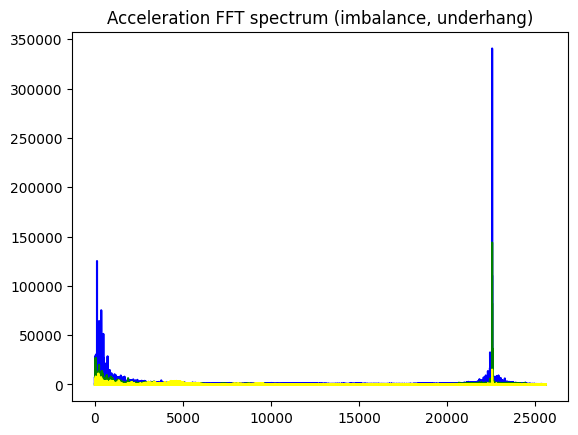

In [24]:
accel_fft_spectrum(df_imb.iloc[:,1].values, df_imb.iloc[:,2].values, df_imb.iloc[:,3].values, df_imb.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (imbalance, underhang)")
plt.show()

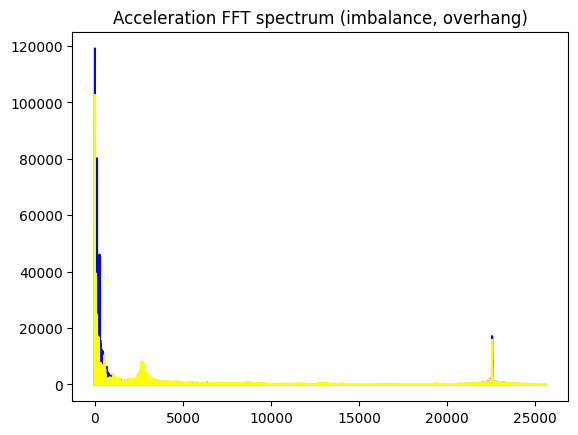

In [25]:
accel_fft_spectrum(df_imb.iloc[:,4].values, df_imb.iloc[:,5].values, df_imb.iloc[:,6].values, df_imb.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (imbalance, overhang)")
plt.show()

In [26]:
n_samples = df_hmis.shape[0]

uhang_x_fft = rfft(df_hmis.iloc[:, 1].values)
uhang_y_fft = rfft(df_hmis.iloc[:, 2].values)
uhang_z_fft = rfft(df_hmis.iloc[:, 3].values)
uhang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

ohang_x_fft = rfft(df_hmis.iloc[:, 4].values)
ohang_y_fft = rfft(df_hmis.iloc[:, 5].values)
ohang_z_fft = rfft(df_hmis.iloc[:, 6].values)
ohang_x_fftfreq = rfftfreq(n_samples, 1/SAMPLE_RATE)

df_fft_imb = pd.DataFrame()
n_fft_samples = len(uhang_x_fft)

df_fft_imb['uhang_x_fft'] = np.abs(uhang_x_fft)
df_fft_imb['uhang_x_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_imb['uhang_y_fft'] = np.abs(uhang_y_fft)
df_fft_imb['uhang_y_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]
df_fft_imb['uhang_z_fft'] = np.abs(uhang_z_fft)
df_fft_imb['uhang_z_fftfreq'] = uhang_x_fftfreq[:n_fft_samples]

df_fft_imb['ohang_x_fft'] = np.abs(ohang_x_fft)
df_fft_imb['ohang_x_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_imb['ohang_y_fft'] = np.abs(ohang_y_fft)
df_fft_imb['ohang_y_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]
df_fft_imb['ohang_z_fft'] = np.abs(ohang_z_fft)
df_fft_imb['ohang_z_fftfreq'] = ohang_x_fftfreq[:n_fft_samples]

df_fft_imb['class'] = 3
df_fft_imb

,uhang_x_fft,uhang_x_fftfreq,uhang_y_fft,uhang_y_fftfreq,uhang_z_fft,uhang_z_fftfreq,ohang_x_fft,ohang_x_fftfreq,ohang_y_fft,ohang_y_fftfreq,ohang_z_fft,ohang_z_fftfreq,class
0,22105.241411,0.000000,1556.740848,0.000000,1249.723217,0.000000,17238.767431,0.000000,10159.848909,0.000000,46015.699872,0.000000,3
1,5871.617487,0.015515,137.937315,0.015515,43.879220,0.015515,22233.508959,0.015515,444.679080,0.015515,38911.028072,0.015515,3
2,7883.267977,0.031030,24.836654,0.031030,108.951272,0.031030,4162.241599,0.031030,41.830329,0.031030,30833.250601,0.031030,3
3,3932.775728,0.046545,119.942327,0.046545,10.162559,0.046545,17950.327467,0.046545,1440.471691,0.046545,28593.702348,0.046545,3
4,5359.993812,0.062061,112.496275,0.062061,171.790382,0.062061,29861.402778,0.062061,676.312560,0.062061,56251.761936,0.062061,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649996,71.959366,25599.937939,68.087177,25599.937939,29.772332,25599.937939,27.446818,25599.937939,2.096013,25599.937939,9.365936,25599.937939,3
1649997,146.989505,25599.953455,86.805935,25599.953455,18.562373,25599.953455,10.403025,25599.953455,0.406089,25599.953455,5.845390,25599.953455,3
1649998,61.837830,25599.968970,124.498933,25599.968970,25.745479,25599.968970,21.774289,25599.968970,4.106327,25599.968970,12.434537,25599.968970,3
1649999,27.400337,25599.984485,90.073291,25599.984485,47.897313,25599.984485,18.378005,25599.984485,6.956911,25599.984485,15.114815,25599.984485,3


In [27]:
df_fft_general = pd.concat([df_fft_normal, df_fft_hmis, df_fft_vmis, df_fft_imb])
df_fft_general.reset_index(inplace=True, drop=True)
df_fft_general

,uhang_x_fft,uhang_x_fftfreq,uhang_y_fft,uhang_y_fftfreq,uhang_z_fft,uhang_z_fftfreq,ohang_x_fft,ohang_x_fftfreq,ohang_y_fft,ohang_y_fftfreq,ohang_z_fft,ohang_z_fftfreq,class
0,21616.221251,0.000000,1567.149749,0.000000,1223.434822,0.000000,23848.618686,0.000000,9972.318879,0.000000,49560.981165,0.000000,0
1,5742.650242,0.015754,105.751529,0.015754,51.932929,0.015754,16691.299925,0.015754,447.578563,0.015754,35183.532660,0.015754,0
2,7845.537518,0.031508,51.593655,0.031508,109.278624,0.031508,8729.590188,0.031508,60.344975,0.031508,33203.617102,0.031508,0
3,4401.388499,0.047262,111.283466,0.047262,14.311252,0.047262,11646.350445,0.047262,1508.572881,0.047262,27581.007948,0.047262,0
4,5235.894598,0.063015,93.537965,0.063015,168.366644,0.063015,31423.161942,0.063015,536.473656,0.063015,56878.048090,0.063015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574999,71.959366,25599.937939,68.087177,25599.937939,29.772332,25599.937939,27.446818,25599.937939,2.096013,25599.937939,9.365936,25599.937939,3
6575000,146.989505,25599.953455,86.805935,25599.953455,18.562373,25599.953455,10.403025,25599.953455,0.406089,25599.953455,5.845390,25599.953455,3
6575001,61.837830,25599.968970,124.498933,25599.968970,25.745479,25599.968970,21.774289,25599.968970,4.106327,25599.968970,12.434537,25599.968970,3
6575002,27.400337,25599.984485,90.073291,25599.984485,47.897313,25599.984485,18.378005,25599.984485,6.956911,25599.984485,15.114815,25599.984485,3


## Model training

### FFT data (classical algorithms)

### RAW data (CNNs)